In [1]:
import os
os.chdir(os.getcwd().replace('/Code', ''))

In [2]:
from pathlib import Path

In [3]:
import pandas as pd
import gzip
import pickle as pkl
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import numpy as np
from scipy.sparse import coo_matrix

from sklearn import decomposition, preprocessing
import seaborn as sns
from sklearn.manifold import TSNE

In [4]:
import gensim, spacy
import gensim.corpora as corpora
from nltk.corpus import stopwords

import pandas as pd
import re
from tqdm import tqdm
import time

In [6]:
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
# import matplotlib.pyplot as plt
# %matplotlib inline

## Setup nlp for spacy
nlp = spacy.load("en_core_web_sm")

# Load NLTK stopwords
stop_words = stopwords.words('english')
# Add some extra words in it if required
stop_words.extend(['from', 'subject', 'use','pron'])

In [74]:
with gzip.open('Matrices/CVs_SW_old.pkl.gz', 'rb') as f:
        CVs = pkl.load(f)
CVs.shape

(8083, 4)

## LDA ANALYSE

In [75]:
data_words=CVs["vocab_cv_list"]

In [76]:
data = data_words.values.tolist()

In [77]:
data_words_clean = list(data)

In [78]:
dictionary = corpora.Dictionary(data_words_clean)


In [79]:
corpus = [dictionary.doc2bow(text) for text in data_words_clean]

In [80]:
data_ready=data_words_clean

In [ ]:
start_time = time.time()
##
NUM_TOPICS = 9
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary,random_state=100,passes=10)
# Saving trained model
ldamodel.save('LDA_NYTBIS')
# Loading trained model
ldamodel = gensim.models.ldamodel.LdaModel.load('LDA_NYTBIS')
## Print time taken to train the model
print("--- %s seconds ---" % (time.time() - start_time))

In [81]:
lda_model = gensim.models.ldamodel.LdaModel.load('LDA_NYTBIS')

In [82]:
lda_model.print_topics(-1)

[(0,
  '0.028*"sql" + 0.028*"server" + 0.018*"environment" + 0.017*"production" + 0.017*"database" + 0.015*"unix" + 0.013*"administration" + 0.012*"support" + 0.010*"shell" + 0.009*"dba"'),
 (1,
  '0.016*"manager" + 0.013*"customer" + 0.009*"digital" + 0.008*"support" + 0.008*"marketing" + 0.008*"service" + 0.007*"sale" + 0.007*"production" + 0.007*"communication" + 0.007*"video"'),
 (2,
  '0.022*"server" + 0.021*"windows" + 0.021*"network" + 0.014*"security" + 0.012*"infrastructure" + 0.011*"deployment" + 0.011*"administration" + 0.010*"cisco" + 0.010*"engineer" + 0.009*"environment"'),
 (3,
  '0.019*"functional" + 0.012*"monitoring" + 0.011*"manager" + 0.010*"specification" + 0.010*"test" + 0.008*"tool" + 0.008*"support" + 0.007*"user" + 0.007*"accounting" + 0.007*"plan"'),
 (4,
  '0.012*"risk" + 0.011*"market" + 0.011*"financial" + 0.011*"office" + 0.009*"analyst" + 0.008*"finance" + 0.007*"support" + 0.007*"customer" + 0.007*"product" + 0.007*"bank"'),
 (5,
  '0.038*"java" + 0.014*

## the Dominant topic and its percentage contribution in each document

In [83]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

In [84]:
def label_topic(num):
    if num==0:
        label="DBA "
    elif num==1:
        label="Media"
    elif num==2:
        label="Sys ops"
    elif num==3:
        label="MOA"
    elif num==4:
        label="Analyste risque"
    elif num==5:
        label="dev Back-End"
    elif num==6:
        label="dev Full Stack"
    elif num==7:
        label="dev Front-End"
    elif num==8:
        label="Data Ing"
    return label
        

In [85]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), label_topic(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Num_Dominant_Topic','Label_topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    num= pd.Series(CVs.index)
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([num, sent_topics_df,contents], axis=1)
    return(sent_topics_df)

In [86]:
df_topic_sents_keywords = format_topics_sentences(lda_model, corpus=corpus, texts=data_ready)


In [87]:
df_dominant_topic = df_topic_sents_keywords
df_dominant_topic.columns = ['ID_CV','Num_Dom_Topic','Label_topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

,ID_CV,Num_Dom_Topic,Label_topic,Topic_Perc_Contrib,Keywords,Text
0,5711,8.0,Data Ing,0.8148,"data, datum, big, r, python, science, university, design, computer, engineer","[junior, data, scientist, junior, data, scientist, bear, paris, valid, international, passport, ..."
1,669,4.0,Analyste risque,0.5280,"risk, market, financial, office, analyst, finance, support, customer, product, bank","[breton, consultant, moa, finance, confirm, domain, financial, market, financial, instrument, eq..."
2,938,2.0,Sys ops,0.5142,"server, windows, network, security, infrastructure, deployment, administration, cisco, engineer,...","[read, write, talk, read, write, talk, read, completion, computer, networking, engineer, iit, in..."
3,1835,5.0,dev Back-End,0.7237,"java, j2ee, design, spring, environment, eclipse, web, engineer, service, test","[java, j2ee, education, oracle, performance, tuning, administration, ccs, graphtalk, aia, bull, ..."
4,266,4.0,Analyste risque,0.4819,"risk, market, financial, office, analyst, finance, support, customer, product, bank","[financial, engineer, financial, engineer, financial, modeling, actuarial, integrity, programmin..."
...,...,...,...,...,...,...
8078,4197,3.0,MOA,0.9920,"functional, monitoring, manager, specification, test, tool, support, user, accounting, plan","[ile, st, harbor, strength, rigorous, dynamic, communicative, cash, consultant, genera, val, man..."
8079,5628,5.0,dev Back-End,0.7004,"java, j2ee, design, spring, environment, eclipse, web, engineer, service, test","[cv, en, r, ad, r, ue, c, r, ot, che, r, ge, rr, c, r, abd, ho, fr, academic, master, computer, ..."
8080,7713,5.0,dev Back-End,0.9012,"java, j2ee, design, spring, environment, eclipse, web, engineer, service, test","[consulting, engineer, architect, developer, web, java, ee, studies, engineer, ismea, option, co..."
8081,781,6.0,dev Full Stack,0.8705,"sql, net, c, test, server, environment, design, visual, asp, software","[master, profile, profile, age, testing, quality, german, profile, command, expert, qa, qm, proc..."


## Find the most representative document for each topic

In [88]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

d=df_dominant_topic.loc[:, df_dominant_topic.columns != 'ID_CV']

sent_topics_outdf_grpd = d.groupby('Label_topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ["Num_Dom_Topic",'Label_topic',"Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.sort_values(by="Num_Dom_Topic")

,Num_Dom_Topic,Label_topic,Topic_Perc_Contrib,Keywords,Text
1,0.0,DBA,0.9993,"sql, server, environment, production, database, unix, administration, support, shell, dba","[manager, applied, computing, institute, dba, studies, production, intervention, bank, telecom, ..."
4,1.0,Media,0.9978,"manager, customer, digital, support, marketing, service, sale, production, communication, video","[bts, audiovisuel, option, exploitation, audiovisual, equipment, audiovisual, manager, functiona..."
5,2.0,Sys ops,0.9983,"server, windows, network, security, infrastructure, deployment, administration, cisco, engineer,...","[monster, cv, jean, claude, citrix, engineer, virtualization, integrate, virtualization, pole, i..."
3,3.0,MOA,0.9985,"functional, monitoring, manager, specification, test, tool, support, user, accounting, plan","[manager, regulatory, risks, master, university, paris, intervention, branch, activity, financia..."
0,4.0,Analyste risque,0.9985,"risk, market, financial, office, analyst, finance, support, customer, product, bank","[calypso, analyst, master, administration, mba, lead, senior, analyst, functional, specification..."
6,5.0,dev Back-End,0.9986,"java, j2ee, design, spring, environment, eclipse, web, engineer, service, test","[ing, independent, j2ee, ista, evry, idf, software, engineer, systems, analyst, j2e, j2e, spring..."
8,6.0,dev Full Stack,0.9990,"sql, net, c, test, server, environment, design, visual, asp, software","[cv, template, msbi, leader, net, leader, msbi, specialize, microsoft, technology, gain, microso..."
7,7.0,dev Front-End,0.9967,"web, developer, php, javascript, design, mysql, jquery, html, technology, js","[stack, javascript, developer, javascript, java, trainee, java, se, developer, javascript, front..."
2,8.0,Data Ing,0.9974,"data, datum, big, r, python, science, university, design, computer, engineer","[cv, dame, ok, format, ons, data, engineer, junior, senegal, real, time, location, datum, custom..."


## List CVs for each topic

In [89]:
d = df_dominant_topic[['Label_topic','ID_CV']]

In [90]:
df_doc_distribution=d.groupby('Label_topic')['ID_CV'].apply(lambda group_series: group_series.tolist()).reset_index()


In [91]:
df_doc_distribution

,Label_topic,ID_CV
0,Analyste risque,"[669, 266, 1279, 2780, 5401, 3502, 1147, 1964, 6586, 2861, 3202, 4589, 1810, 6860, 5958, 6187, 4..."
1,DBA,"[2346, 6621, 1640, 1689, 6434, 2738, 2187, 7449, 6122, 1426, 3614, 1996, 1459, 7465, 2684, 2446,..."
2,Data Ing,"[5711, 1050, 4784, 1301, 352, 1055, 1458, 1882, 1415, 1320, 4657, 8759, 5914, 6027, 4782, 5607, ..."
3,MOA,"[2064, 961, 4890, 7972, 5009, 2956, 1665, 4001, 7571, 3428, 4687, 7072, 3661, 3841, 3408, 7718, ..."
4,Media,"[8376, 1249, 3729, 6013, 1378, 247, 6877, 3315, 6020, 3995, 2006, 1304, 2333, 5660, 1895, 763, 7..."
5,Sys ops,"[938, 1493, 109, 2304, 5905, 5760, 6285, 2121, 6454, 1591, 2733, 4089, 7659, 1302, 2851, 5572, 2..."
6,dev Back-End,"[1835, 6433, 7686, 4088, 4727, 591, 8457, 7116, 975, 7710, 295, 3035, 6725, 1735, 3914, 8185, 15..."
7,dev Front-End,"[2620, 1461, 4722, 3050, 5487, 2774, 2042, 8426, 7981, 7113, 7200, 3509, 6211, 5894, 2110, 3999,..."
8,dev Full Stack,"[3384, 2238, 6172, 3964, 3479, 2096, 1818, 609, 1951, 303, 7422, 740, 2716, 1934, 7942, 4894, 86..."


# Number of CVs per Topic


In [92]:
df_topic_distribution = df_dominant_topic['Label_topic'].value_counts().reset_index(name="Nbr Documents")
df_topic_distribution.columns = ['Topic', 'Nbr Documents']
df_topic_distribution.sort_values(by='Topic')

,Topic,Nbr Documents
0,Analyste risque,1721
7,DBA,420
4,Data Ing,895
3,MOA,974
6,Media,683
8,Sys ops,412
2,dev Back-End,1039
1,dev Front-End,1228
5,dev Full Stack,711


In [93]:
df_topic_distribution.index=df_topic_distribution['Topic']

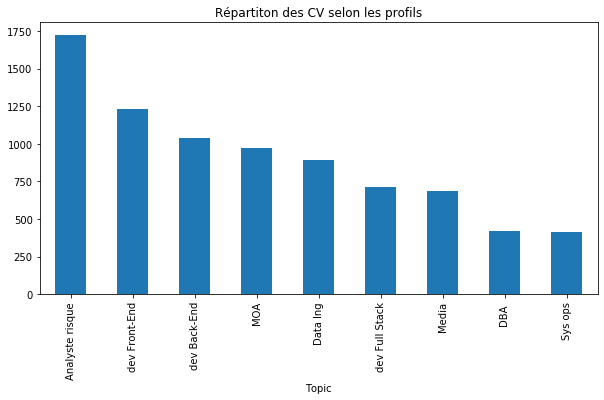

In [94]:
plt.figure(figsize=(10, 5))
df_topic_distribution.sort_values(by='Nbr Documents', ascending=False).head(20)['Nbr Documents'].plot(kind='bar',title = 'Répartiton des CV selon les profils')

plt.show()

## Word Clouds of Top N Keywords in Each Topic

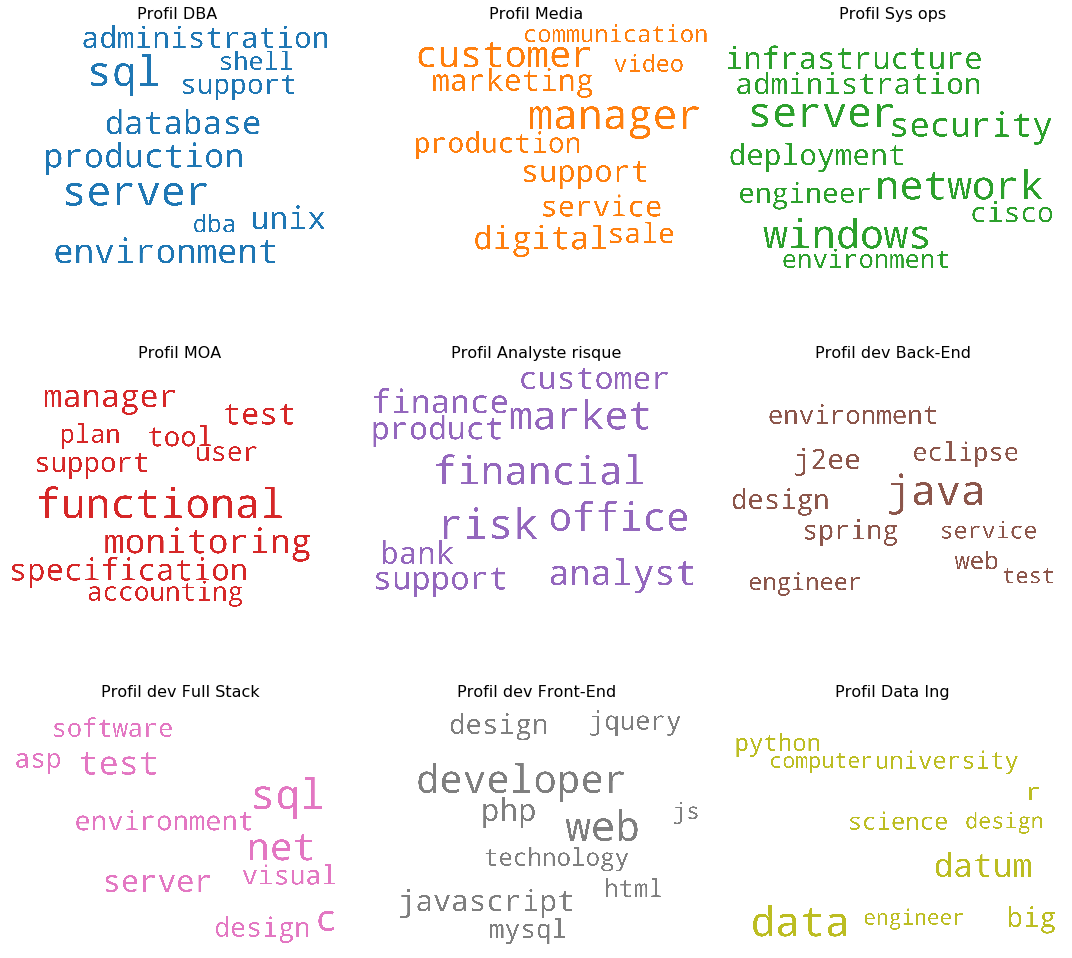

In [95]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3,3, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Profil ' + label_topic(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Word Counts of Topic Keywords


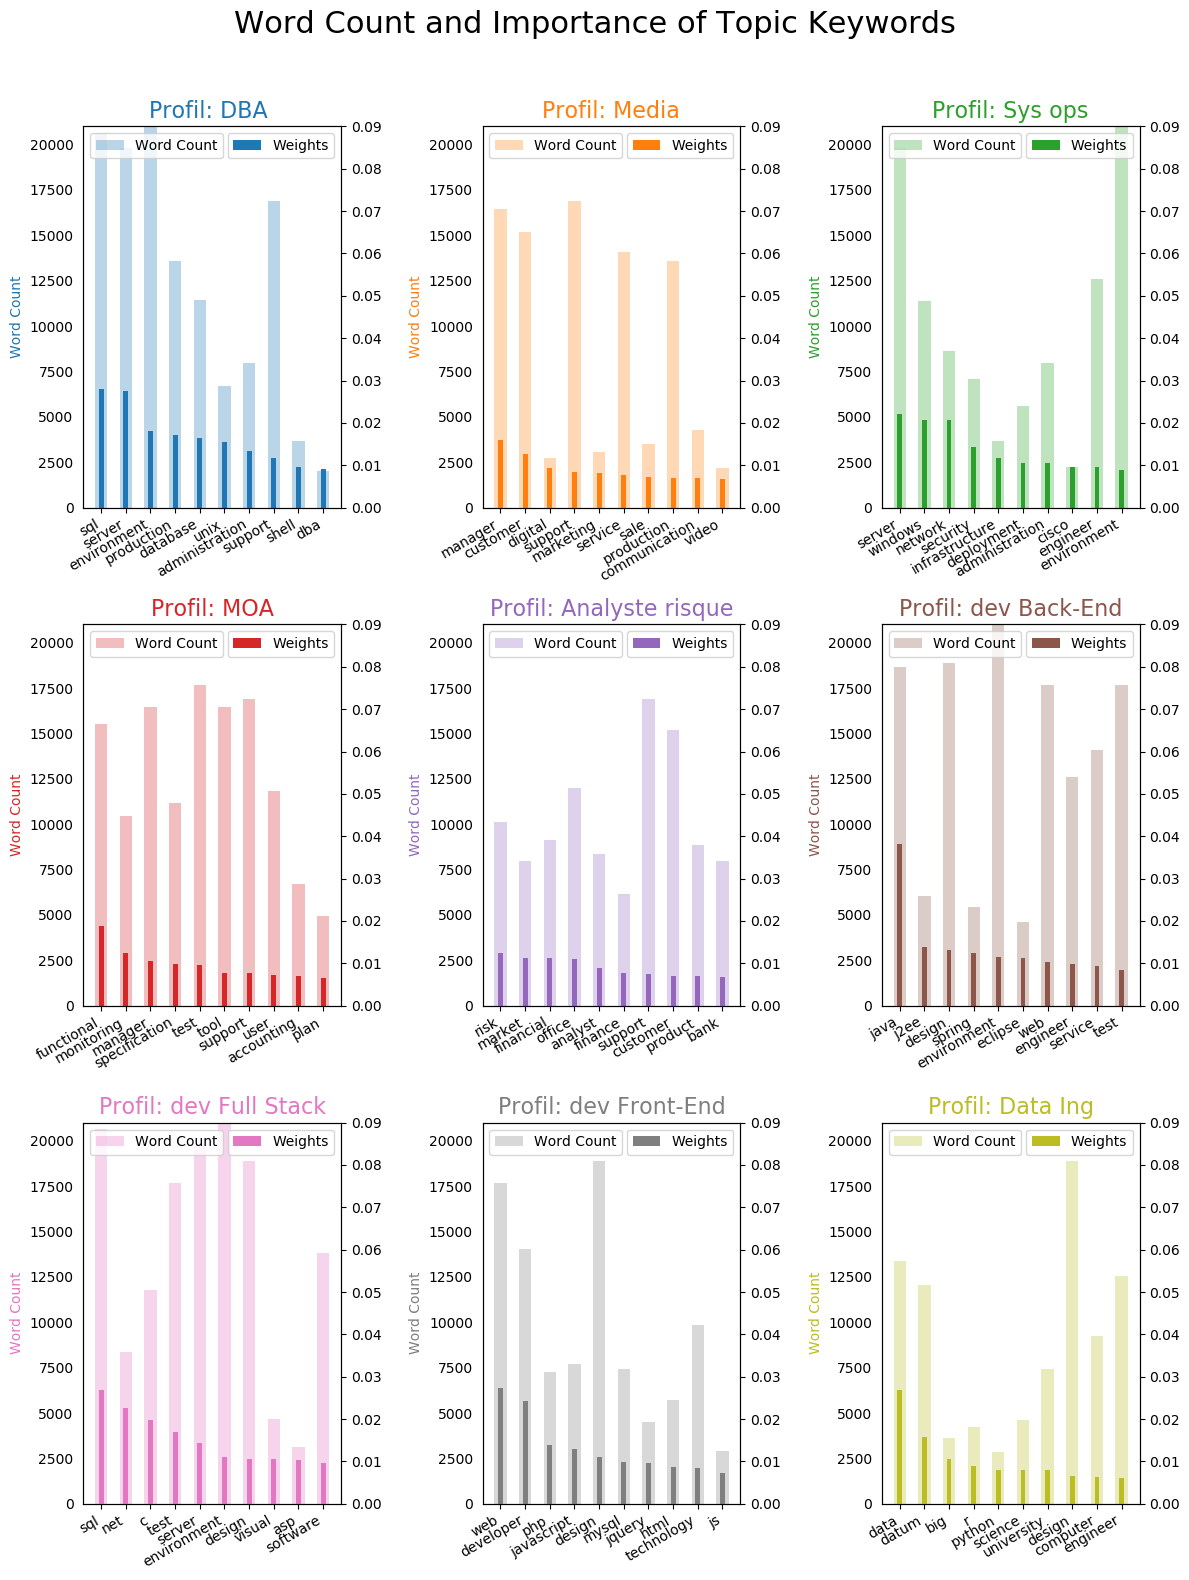

In [96]:
from collections import Counter

topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count']) 
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3,3, figsize=(12,15), dpi=100)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.090); ax.set_ylim(0, 21000)
    ax.set_title('Profil: ' + label_topic(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## t-SNE Clustering Chart


In [97]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 9
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7439 samples in 0.007s...
[t-SNE] Computed neighbors for 7439 samples in 0.262s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7439
[t-SNE] Computed conditional probabilities for sample 2000 / 7439
[t-SNE] Computed conditional probabilities for sample 3000 / 7439
[t-SNE] Computed conditional probabilities for sample 4000 / 7439
[t-SNE] Computed conditional probabilities for sample 5000 / 7439
[t-SNE] Computed conditional probabilities for sample 6000 / 7439
[t-SNE] Computed conditional probabilities for sample 7000 / 7439
[t-SNE] Computed conditional probabilities for sample 7439 / 7439
[t-SNE] Mean sigma: 0.009110
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.503983
[t-SNE] KL divergence after 1000 iterations: 1.083642


Loading BokehJS ...

## pyLDAVis


In [64]:
# To plot at Jupyter notebook
pyLDAvis.enable_notebook()
plot = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
#Save pyLDA plot as html file
pyLDAvis.save_html(plot, 'LDA_NYTBIS.html')
plot


/home/gabouj/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.043523 -0.160829       1        1  18.157856
4      0.047893 -0.201941       2        1  18.045595
5      0.036709  0.152713       3        1  12.337571
6     -0.001919  0.085117       4        1  10.507636
7      0.189032  0.114214       5        1   9.963320
8      0.110168  0.025513       6        1   8.760098
0     -0.192212  0.076959       7        1   8.552832
1      0.063398 -0.115790       8        1   7.231324
2     -0.209548  0.024044       9        1   6.443758, topic_info=     Category          Freq      Term         Total  loglift  logprob
116   Default  18530.000000      java  18530.000000  30.0000  30.0000
220   Default  22899.000000       sql  22899.000000  29.0000  29.0000
738   Default  20675.000000    server  20675.000000  28.0000  28.0000
152   Default   8558.000000       net   8558.000000  27.0000  27.0000
252   Default  16804.000000       web  16804.000000  26.0000  26.0000
...       ...           ...       ...           ...      ...      ...
210    Topic9   1245.085083   service  14003.118164   0.3220  -5.1213
1058   Topic9    913.937866   systems   3392.436035   1.4305  -5.4305
52     Topic9   1045.917358  computer   9750.124023   0.5097  -5.2957
548    Topic9   1039.579468      user  11330.424805   0.3534  -5.3017
668    Topic9   1038.331299   manager  16346.964844  -0.0144  -5.3029

[745 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
8780       7  0.984404       11gr
8781       7  0.994714      11gr2
10278      7  0.994341        11i
1991       2  0.005060         8i
1991       3  0.126494         8i
...      ...       ...        ...
561        8  0.000167        xml
11305      1  0.985497       xrdj
3204       6  0.988617       yarn
2793       5  0.998943       zend
1718       6  0.997879  zookeeper

[2254 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 6, 7, 8, 9, 1, 2, 3])